@Author: Romy Beauté\
@Contact: r.beaut@sussex.ac.uk\
@Date: 07-2023\
@Last modification: 08-03-2024

In [1]:
# %matplotlib widget
%matplotlib inline

import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import sys
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D




#import helpers functions manually created
project_path = os.path.abspath('/Users/rb666/projects/TopicModelling_META')
if project_path not in sys.path:
    sys.path.append(project_path)
from helpers.BERT_helpers import *


#Select parameters for dataset and preprocessing
HighSensory = True #If False, corresponds to deep listening experience (no flicker)
remove_stopwords = False
extended_stopwords = False
vectorizer = False


/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelli

# Prepare reports dataset

In [2]:
dataset_name = "SensoryTool_CombinedData.csv"
metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'

condition = 'highsensory' if HighSensory else 'deeplistening'
print(f'Condition : "{condition}"')

PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')

df = pd.read_csv(DATADIR)
dataset = df[df['meta_HighSensory'] == HighSensory]['reflection_answer']
reports = dataset[dataset.notna() & (dataset != '')]

print('N={} reports (HighSensory = {})'.format(len(reports),HighSensory))
reports.head()


Condition : "highsensory"
N=336 reports (HighSensory = True)


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_2016/1674985168.py:12: DtypeWarning: Columns (23,24,71,73,75,77,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,157,159,161,165,168,196,203,205) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATADIR)


83     Intense chaos. And then my mind checked out an...
99                                         good stuff.\n
120    a pattern of red and white lights thatflashed ...
172    i wentback to many hard and mostly beautiful m...
189                                                Hello
Name: reflection_answer, dtype: object

### Start preprocessing

If vectorised used:\  
From model.fit_transform we return two lists:\

- topics contains a one-to-one mapping of inputs to their modeled topic (or cluster).
- probs contains a list of probabilities that an input belongs to their assigned topic.



NB : as we removed stop words (either via manually implemented function, or via vectorizer model), the top -1 topic represents the most generic topic. If we did not have removed stopwords, it would represents the irrelevant words (like "the", "and","I",...) that are the most used in english language
Here, we see that the most generic topic evolve around : like, experience, saw, felt   

In [3]:
#select stop words to remove
if not vectorizer:
    stop_words = set(stopwords.words('english'))
    if extended_stopwords:
        stop_words = stop_words.union(custom_stopwords) #load custom stopwords from BERT_helpers.py

    reports_cleaned = reports.apply(clean_text) #clean text using helper function
    reports_filtered = reports_cleaned[reports_cleaned.apply(lambda x: len(x.split()) > 1)]

    print(reports_filtered.head())
    #print the number of reports after cleaning
    print('N={} reports after cleaning'.format(len(reports_filtered)))

else:
    reports_filtered = reports[reports.apply(lambda x: len(x.split()) > 1)] 
    print(f"Reports filtered before vectorizer :\n {reports_filtered.head()}")
    print('N={} reports after cleaning'.format(len(reports_filtered)))
    # print(reports_filtered)

    # create vectorizer model to remove stopwords and create ngrams 
    vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

    model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True) #set verbose to True to see the progress of the model
    topics, probs = model.fit_transform(reports_filtered)

    freq = model.get_topic_info() #acees the freq topics that were generated
    print(freq.head(10))
    

83     intense chaos mind checked subconscious took s...
99                                            good stuff
120    pattern red white lights thatflashed andbecame...
172    wentback many hard mostly beautiful memories w...
191                                          hope colour
Name: reflection_answer, dtype: object
N=312 reports after cleaning


Have a deeper look at the most frequent topic that was generated (topic 0). Here we see that it largely corresponds to simple visual hallucinations : visual components characterised by shapes, colours, geometric patterns 

In [4]:
if vectorizer:
    model.get_topic(0)
    model.visualize_hierarchy()
    model.visualize_barchart()

# 1. Embedding

The embedding process involves encoding the list of preprocessed texts from participants' open reports into vector representations. This conversion is facilitated by a pre-trained Sentence Transformer model. To ensure efficiency, especially with large datasets, the process is executed in batches.
More specifically, to encode our text to dense vector embeddings, we used the all-MiniLM-L6-v2 model from the sentence-transformers library of the Hugging Face Hub, mapping sentences and paragraphs to a 384 dimensional dense vector space. Text is embedded in vector space such that similar text are closer and can efficiently be found using cosine similarity.

Ressources :\
- https://www.pinecone.io/learn/series/nlp/sentence-embeddings/
- https://pypi.org/project/sentence-transformers/

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2') #Loads pre-trained Sentence Transformer model 'all-MiniLM-L6-v2'
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

Create the embedding using batches of data

In [6]:
data = reports_filtered.tolist() #for later use

n = len(data)
print(n)
batch_size = 16 #number of doc embeddings at the time

embeds = np.zeros((n, model.get_sentence_embedding_dimension()))

for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = data[i:i_end]
    batch_embed = model.encode(batch)
    embeds[i:i_end,:] = batch_embed

312


  0%|          | 0/20 [00:00<?, ?it/s]

# 2. UMAP Dimensionality reduction 

At the moment we have 384 dimensions, and we don't need them all to fit the information we mean to classify the meaning of our documents 
Advantage with UMAP : we can find the k neighbours that are neither too small (preserve only local structure) neither too large (preserve only global structure), but find something in between to preserve both local and global structures.

NB : As we dont have labelled data, harder to check the clusters visually

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


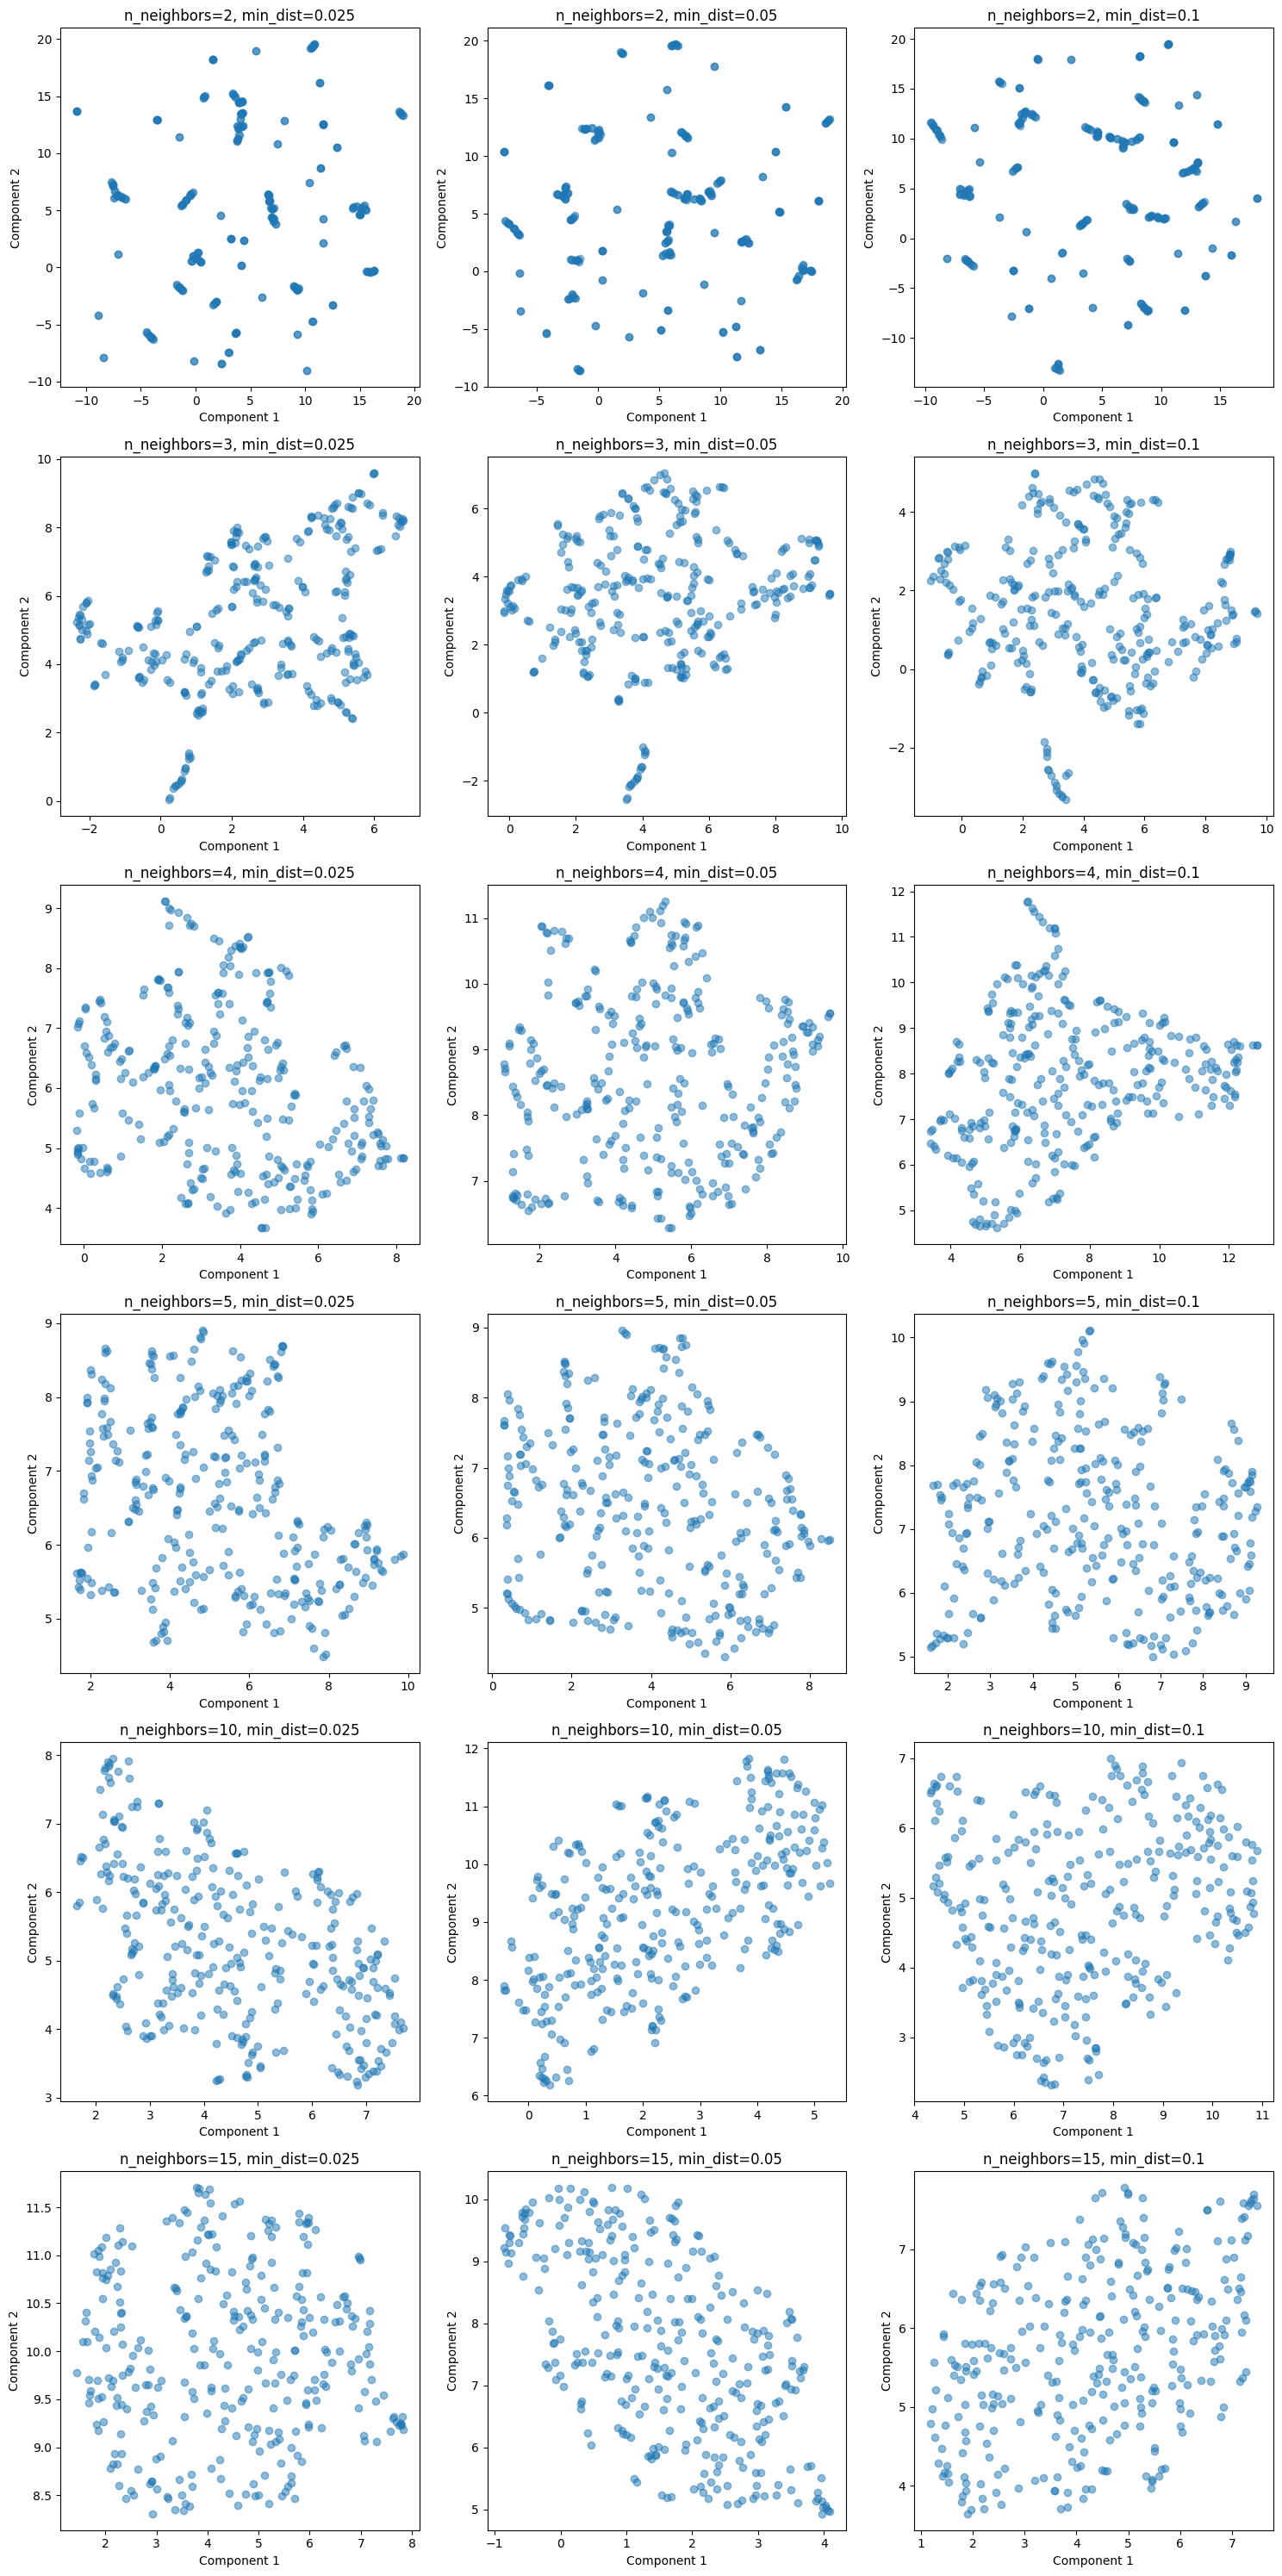

In [102]:
#We first check different values of n_neighbors and min_dist to see how they affect the UMAP plot and filter out the worst values 

import umap


# UMAP configuration
nns = [2, 3, 4, 5, 10, 15]
min_dist = [0.025,0.05, 0.1]
n_components =  2 # This determines whether plots are 2D or 3D

# Calculate grid dimensions
num_rows = len(nns)
num_cols = len(min_dist)
fig = plt.figure(figsize=(5 * num_cols, 5 * num_rows))  # Adjust size accordingly

# Loop through combinations of n_neighbors and min_dist
for i, n_neighbors in enumerate(tqdm(nns)):
    for j, min_d in enumerate(min_dist):
        # Calculate subplot index for current combination
        plot_index = (i * num_cols) + j + 1
        
        # UMAP fitting
        fit = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_d, random_state=42)
        u = fit.fit_transform(embeds)

        if n_components == 3:
            ax = fig.add_subplot(num_rows, num_cols, plot_index, projection='3d')
            scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], alpha=0.5)
            ax.set_zlabel('Component 3')
        else:
            ax = fig.add_subplot(num_rows, num_cols, plot_index)
            scatter = ax.scatter(u[:, 0], u[:, 1], alpha=0.5)

        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_d}')

plt.tight_layout()
plt.show()


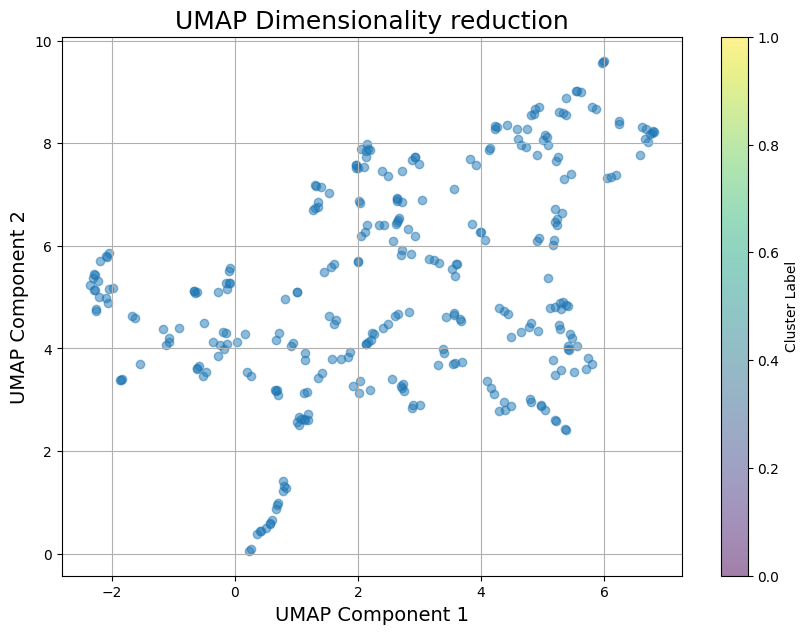

In [103]:
# then try with the parameters thhat gave the best results

from mpl_toolkits.mplot3d import Axes3D

#define hyperparameters for UMAP and see how they affect the dimensionality reduction
n_components = 2 #number of components to reduce the data to, default is 2
n_neighbors = 3 #number of neighbors to consider for each point, default is 15
min_dist = 0.025 #minimum distance between points in the embedding space, default is 0.1

fit = umap.UMAP(n_components=n_components, # by default this is 2
                n_neighbors=n_neighbors, # by default this is 15
                min_dist=min_dist, # by default this is 0.1
                random_state=42
                )  
u = fit.fit_transform(embeds)



# u contains our 2-dimensional embeddings after applying UMAP
x = u[:, 0]  # x-coordinates
y = u[:, 1]  # y-coordinates

fig = plt.figure(figsize=(10, 7))

if n_components>2:
    ax = fig.add_subplot(111, projection='3d')  # 3D projection for more than 2 components
    scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], cmap='viridis', alpha=0.5)
    ax.set_zlabel('UMAP Component 3', fontsize=14)
    
else:
    ax = fig.add_subplot(111)  # Default 2D projection
    scatter = ax.scatter(u[:, 0], u[:, 1], cmap='viridis', alpha=0.5)



plt.colorbar(scatter, label='Cluster Label')

ax.set_title('UMAP Dimensionality reduction', fontsize=18)
ax.set_xlabel('UMAP Component 1', fontsize=14)
ax.set_ylabel('UMAP Component 2', fontsize=14)

plt.grid(True)  # Add a grid for easier visualization (optional)
plt.show()



# Clusters with HDBSCAN

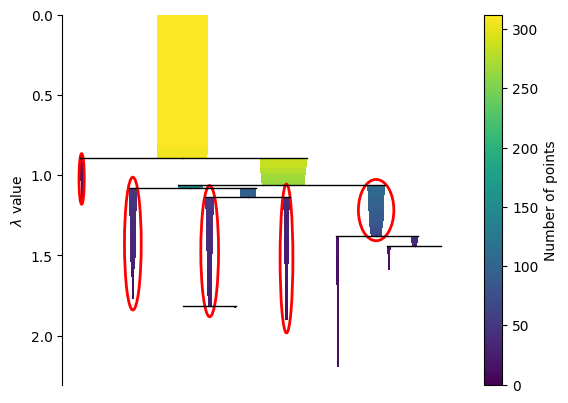

In [117]:
%matplotlib inline

import hdbscan

clusters = hdbscan.HDBSCAN(
    min_cluster_size=11,  #default value to 5 : the smallest size grouping that we consider to be a cluster
    min_samples=None) #default value to = min_cluster_size : determine the density of an area. Higher values denote stricter definitions of what constitutes a dense area
clusters.fit(u)

cluster_labels = clusters.fit_predict(u)


clusters.condensed_tree_.plot(select_clusters=True) #see how our clusters are being built
plt.show()


In [118]:
from sklearn.metrics import silhouette_score
score = silhouette_score(u, cluster_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.3365500569343567


312


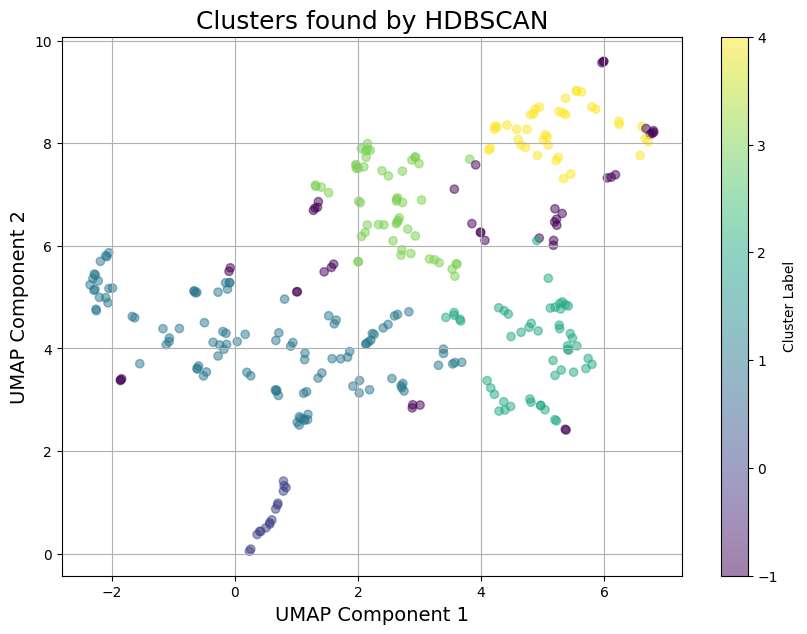

In [119]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


labels = clusters.labels_
print(len(labels))

n_components = u.shape[1]

fig = plt.figure(figsize=(10, 7))
if n_components > 2:
    ax = fig.add_subplot(111, projection='3d')  # 3D projection for more than 2 components
    scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=labels, cmap='viridis', alpha=0.5)
    ax.set_zlabel('UMAP Component 3', fontsize=14)
else:
    ax = fig.add_subplot(111)  # Default 2D projection
    scatter = ax.scatter(u[:, 0], u[:, 1], c=labels, cmap='viridis', alpha=0.5)

plt.colorbar(scatter, label='Cluster Label')

ax.set_title('Clusters found by HDBSCAN', fontsize=18)
ax.set_xlabel('UMAP Component 1', fontsize=14)
ax.set_ylabel('UMAP Component 2', fontsize=14)

plt.grid(True)  # Add a grid for easier visualization (optional)
plt.show()

# Find topics (c-TF-IDF)

In [120]:
import nltk


print(len(cluster_labels)) #check we have the same len as data and tokens

tokenized_data = [nltk.tokenize.wordpunct_tokenize(sentence) for sentence in data]
print(len(tokenized_data))

d = {'tokens':tokenized_data,'class': cluster_labels}
df = pd.DataFrame(data=d)
df


312
312


,tokens,class
0,"[intense, chaos, mind, checked, subconscious, ...",1
1,"[good, stuff]",-1
2,"[pattern, red, white, lights, thatflashed, and...",3
3,"[wentback, many, hard, mostly, beautiful, memo...",-1
4,"[hope, colour]",4
...,...,...
307,"[changing, temperature, body, lights, changes,...",1
308,"[pleasure, intrigue]",1
309,"[travelling, space]",2
310,"[thought, alot, rands, journey, rhudian, exper...",1


In [121]:
# Aggregate tokens by class
class_aggregated_tokens = df.groupby('class')['tokens'].agg(sum)
all_tokens = [token for sublist in tokenized_data for token in sublist] ## Flatten the list of tokenized data to get a single list of all tokens

# Convert to a set to get unique tokens, then back to a list to make it indexable
vocab = list(set(all_tokens))
print(f"Vocabulary Size: {len(vocab)}")


Vocabulary Size: 1961


In [122]:
tf = np.zeros((len(class_aggregated_tokens), len(vocab)))

for c, tokens in enumerate(tqdm(class_aggregated_tokens)):
    for t, term in enumerate(vocab):
        tf[c, t] = tokens.count(term)

100%|██████████| 6/6 [00:00<00:00, 86.22it/s]


In [123]:
# init the TF matrix: rows are clusters, columns are words in vocab
tf = np.zeros((len(class_aggregated_tokens), len(vocab)))

# populate the TF matrix
for cluster_id, tokens in enumerate(class_aggregated_tokens):
    for word in tqdm(vocab):
        #  how many times each word appears in each cluster's tokens
        tf[cluster_id][vocab.index(word)] = tokens.count(word)

tf

100%|██████████| 1961/1961 [00:00<00:00, 83942.58it/s]


array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 3., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

idf

100%|██████████| 1961/1961 [00:00<00:00, 603184.96it/s]


array([[6.63397611, 6.63397611, 5.53799022, ..., 5.94214299, 5.53799022,
        6.63397611]])

In [125]:
tf_idf = tf*idf
tf_idf

array([[ 0.        ,  6.63397611,  0.        , ...,  0.        ,
         0.        ,  6.63397611],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.53799022, ..., 11.88428598,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 6.63397611,  0.        , 11.07598044, ...,  0.        ,
        16.61397066,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [126]:
n = 8 #number of top words to display
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
top_idx

array([[ 577, 1713,  713,  953,  702, 1429, 1083, 1732],
       [ 372, 1838, 1731,  748,  995,  180, 1388,  287],
       [1523, 1650,  922, 1811,  565, 1594,  748, 1681],
       [1133, 1594,  977,  922, 1487,  841, 1231,   70],
       [  40,  408,  748, 1231,  795, 1643,  266, 1594],
       [1594,  702,  259,  795, 1133, 1800,  122, 1487]])

In [127]:
vlist = list(vocab)

for c, _class in enumerate(class_aggregated_tokens):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(topn_terms)

['sense', 'good', 'time', 'away', 'moving', 'towards', 'sound', 'memories']
['awesome', 'beats', 'expected', 'experience', 'back', 'music', 'first', 'calming']
['people', 'body', 'felt', 'peace', 'thoughts', 'like', 'experience', 'calm']
['one', 'like', 'space', 'felt', 'shapes', 'universe', 'saw', 'stars']
['feel', 'would', 'experience', 'saw', 'colours', 'could', 'blue', 'like']
['like', 'moving', 'patterns', 'colours', 'one', 'sometimes', 'red', 'shapes']


# EVALUATION

Implementation of the Parameter Search


In [128]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np
from tqdm import tqdm

# Update the parameter grid setup
umap_params = {
    'n_components': [2, 3],
    'n_neighbors': [2, 3, 4, 5, 10],
    'min_dist': [0.025,0.05, 0.1],  # Added min_dist
}

hdbscan_params = {
    'min_cluster_size': [3, 4, 5, 6, 8, 10],
    # Removing min_samples from the grid since it will be the same as min_cluster_size
}



# Initialize metrics
best_silhouette = -1
best_davies_bouldin = float('inf')  # Davies-Bouldin should be minimized
best_calinski_harabasz = -1

best_params_silhouette = {}
best_params_davies_bouldin = {}
best_params_calinski_harabasz = {}

total_iterations = len(umap_params['n_components']) * len(umap_params['n_neighbors']) * len(umap_params['min_dist']) * len(hdbscan_params['min_cluster_size'])
pbar = tqdm(total=total_iterations, desc='Evaluating Combinations')

# Loop through parameter grid
for n_components in umap_params['n_components']:
    for n_neighbors in umap_params['n_neighbors']:
        for min_dist in umap_params['min_dist']:
            umap_embeddings = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,random_state=42).fit_transform(embeds)
            
            for min_cluster_size in hdbscan_params['min_cluster_size']:
                min_samples = min_cluster_size  # Ensure min_samples equals min_cluster_size
                
                clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit(umap_embeddings)
                labels = clusterer.labels_
                
                # Skip if only one cluster is found
                if len(set(labels)) <= 1:
                    pbar.update(1)
                    continue
                
                silhouette = silhouette_score(umap_embeddings, labels)
                davies_bouldin = davies_bouldin_score(umap_embeddings, labels)
                calinski_harabasz = calinski_harabasz_score(umap_embeddings, labels)
                
                # Check if this combination is the best for each metric
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params_silhouette = {'n_components': n_components, 'n_neighbors': n_neighbors, 'min_dist': min_dist, 'min_cluster_size': min_cluster_size}
                
                if davies_bouldin < best_davies_bouldin:
                    best_davies_bouldin = davies_bouldin
                    best_params_davies_bouldin = {'n_components': n_components, 'n_neighbors': n_neighbors, 'min_dist': min_dist, 'min_cluster_size': min_cluster_size}
                
                if calinski_harabasz > best_calinski_harabasz:
                    best_calinski_harabasz = calinski_harabasz
                    best_params_calinski_harabasz = {'n_components': n_components, 'n_neighbors': n_neighbors, 'min_dist': min_dist, 'min_cluster_size': min_cluster_size}
                
                pbar.update(1)

pbar.close()

print("Best Parameters for Silhouette Score:", best_params_silhouette, "with a score of", best_silhouette)
print("Best Parameters for Davies-Bouldin Index:", best_params_davies_bouldin, "with a score of", best_davies_bouldin)
print("Best Parameters for Calinski-Harabasz Score:", best_params_calinski_harabasz, "with a score of", best_calinski_harabasz)



Evaluating Combinations: 100%|██████████| 180/180 [00:17<00:00, 10.24it/s]

Best Parameters for Silhouette Score: {'n_components': 3, 'n_neighbors': 2, 'min_dist': 0.025, 'min_cluster_size': 4} with a score of 0.695177
Best Parameters for Davies-Bouldin Index: {'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.05, 'min_cluster_size': 6} with a score of 0.5713680455605784
Best Parameters for Calinski-Harabasz Score: {'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.025, 'min_cluster_size': 8} with a score of 142.1283570826673


Define sampling and Clustering Function to assess cluster stability

In [129]:
from sklearn.metrics import adjusted_rand_score

umap_params = {
    'n_components': [2, 3, 4, 5],
    'n_neighbors': [2, 3, 4, 5, 10],
    'min_dist': [0.025,0.05, 0.1, 0.25],  
}

hdbscan_params = {
    'min_cluster_size': [3, 4, 5, 6, 8, 10],
}


def cluster_stability(data, n_samples=100, n_repeats=10, umap_params=None, hdbscan_params=None):
    """
    Assess the stability of clustering by subsampling and calculating ARI.
    
    Parameters:
    - data: The dataset to be clustered (assumed to be a numpy array or pandas DataFrame).
    - n_samples: Number of samples to draw in each subsample.
    - n_repeats: Number of repeats for subsampling and clustering.
    - umap_params: Parameters for UMAP as a dict.
    - hdbscan_params: Parameters for HDBSCAN as a dict.
    
    Returns:
    - The average ARI score across all pairs of clustering results.
    """
    if umap_params is None:
        umap_params = {'n_components': 3, 'n_neighbors': 2}
    if hdbscan_params is None:
        hdbscan_params = {'min_cluster_size': 5, 'min_samples': 5}

    #  data needs to be a numpy array for consistent indexing
    if isinstance(data, pd.DataFrame):
        data = data.values

    labels_list = []
    for _ in tqdm(range(n_repeats)):
        # Randomly sample data
        idx = np.random.choice(range(data.shape[0]), size=n_samples, replace=False)
        data_sample = data[idx]

        # UMAP reduction
        umap_reducer = UMAP(**umap_params)
        data_reduced = umap_reducer.fit_transform(data_sample)

        # HDBSCAN clustering
        clusterer = HDBSCAN(**hdbscan_params)
        clusterer.fit(data_reduced)
        labels_list.append(clusterer.labels_)

    # Calculate ARI between all pairs of clustering results
    ari_scores = []
    for i in range(len(labels_list)):
        for j in range(i + 1, len(labels_list)):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_scores.append(ari)

    return np.mean(ari_scores)


# use best parameters obtained from our earlier optimization
best_umap_params = {'n_components': 2, 'n_neighbors': 3,'min_dist': 0.025}
best_hdbscan_params = {'min_cluster_size': 11, 'min_samples': None}


average_ari = cluster_stability(embeds, n_samples=250, n_repeats=35, umap_params=best_umap_params, hdbscan_params=best_hdbscan_params)

print(f"Average Adjusted Rand Index (ARI) across all runs: {average_ari}")


100%|██████████| 35/35 [00:30<00:00,  1.15it/s]

Average Adjusted Rand Index (ARI) across all runs: -0.00034975362734280185


In [130]:
import itertools
from bertopic import BERTopic
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from umap import UMAP

umap_params = {
    'n_components': [2],#[2, 3, 4]
    'n_neighbors': [2,3,4],
    'min_dist': [0.03,0.05]  
}

hdbscan_params = {
    'min_cluster_size': [6,8,10]

}



data = reports_filtered.tolist()

# Define function to calculate Jaccard similarity between two sets of topics
def calculate_jaccard_similarity(topics_a, topics_b):
    mlb = MultiLabelBinarizer()
    y_a = mlb.fit_transform([topics_a])
    y_b = mlb.transform([topics_b])
    # Avoid division by zero
    if not y_a.any() or not y_b.any():  
        return 0
    return jaccard_score(y_a[0], y_b[0], average='macro')

def run_bertopic(data, umap_params, hdbscan_params):
    # Instantiate UMAP and HDBSCAN with the provided parameters
    umap_model = UMAP(**umap_params)
    hdbscan_model = hdbscan.HDBSCAN(**hdbscan_params)
    
    # Initialize BERTopic with the instantiated UMAP and HDBSCAN models
    model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics, _ = model.fit_transform(data)
    return set(model.get_topics().keys())

# Generate all combinations of UMAP and HDBSCAN parameters
umap_param_list = [dict(zip(umap_params, v)) for v in itertools.product(*umap_params.values())]
hdbscan_param_list = [dict(zip(hdbscan_params, v)) for v in itertools.product(*hdbscan_params.values())]

n_iter = 5  # Number of iterations to ensure stability
stability_scores = []

# Iterate over all parameter combinations
for umap_param, hdbscan_param in itertools.product(umap_param_list, hdbscan_param_list):
    print(f"Testing combination: UMAP={umap_param}, HDBSCAN={hdbscan_param}")
    topics_sets = []
    for _ in range(n_iter):
        topics = run_bertopic(data, umap_param, hdbscan_param)
        topics_sets.append(topics)

    # Calculate pairwise Jaccard similarities for stability
    pairwise_similarities = [calculate_jaccard_similarity(set_a, set_b) 
                             for set_a, set_b in itertools.combinations(topics_sets, 2)]
    stability_score = np.mean(pairwise_similarities)
    stability_scores.append(((umap_param, hdbscan_param), stability_score))

# Find the parameters with the highest stability score
best_params, best_score = max(stability_scores, key=lambda x: x[1])
print(f"Best parameters for stability: UMAP={best_params[0]}, HDBSCAN={best_params[1]}, Stability Score: {best_score}")


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:30:41,440 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:42,250 - BERTopic - Reduced dimensionality
2024-04-05 15:30:42,255 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:43,168 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:43,942 - BERTopic - Reduced dimensionality
2024-04-05 15:30:43,947 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:44,889 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:45,994 - BERTopic - Reduced dimensionality
2024-04-05 15:30:46,000 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:46,958 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:47,760 - BERTopic - Reduced dimensionality
2024-04-05 15:30:47,765 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:48,723 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:49,535 - BERTopic - Reduced dimensionality
2024-04-05 15:30:49,541 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:30:50,498 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:51,315 - BERTopic - Reduced dimensionality
2024-04-05 15:30:51,320 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:52,410 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:53,232 - BERTopic - Reduced dimensionality
2024-04-05 15:30:53,237 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:54,204 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:55,331 - BERTopic - Reduced dimensionality
2024-04-05 15:30:55,336 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:56,317 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:57,135 - BERTopic - Reduced dimensionality
2024-04-05 15:30:57,140 - BERTopic - Clustered reduced embeddings
2024-04-05 15:30:58,096 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:30:58,916 - BERTopic - Reduced dimensionality
2024-04-05 15:30:58,922 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:30:59,898 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:00,723 - BERTopic - Reduced dimensionality
2024-04-05 15:31:00,728 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:01,679 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:02,488 - BERTopic - Reduced dimensionality
2024-04-05 15:31:02,493 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:03,408 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:04,218 - BERTopic - Reduced dimensionality
2024-04-05 15:31:04,224 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:05,172 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:06,350 - BERTopic - Reduced dimensionality
2024-04-05 15:31:06,356 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:07,279 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:08,044 - BERTopic - Reduced dimensionality
2024-04-05 15:31:08,049 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:31:09,004 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:09,805 - BERTopic - Reduced dimensionality
2024-04-05 15:31:09,810 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:10,734 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:11,538 - BERTopic - Reduced dimensionality
2024-04-05 15:31:11,543 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:12,564 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:13,421 - BERTopic - Reduced dimensionality
2024-04-05 15:31:13,426 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:14,423 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:15,258 - BERTopic - Reduced dimensionality
2024-04-05 15:31:15,263 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:16,213 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:17,354 - BERTopic - Reduced dimensionality
2024-04-05 15:31:17,359 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:31:18,303 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:19,116 - BERTopic - Reduced dimensionality
2024-04-05 15:31:19,120 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:20,045 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:20,895 - BERTopic - Reduced dimensionality
2024-04-05 15:31:20,899 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:21,875 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:22,643 - BERTopic - Reduced dimensionality
2024-04-05 15:31:22,648 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:23,629 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:24,456 - BERTopic - Reduced dimensionality
2024-04-05 15:31:24,460 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:25,457 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:26,624 - BERTopic - Reduced dimensionality
2024-04-05 15:31:26,629 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 2, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:31:27,596 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:28,440 - BERTopic - Reduced dimensionality
2024-04-05 15:31:28,445 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:29,362 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:30,205 - BERTopic - Reduced dimensionality
2024-04-05 15:31:30,210 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:31,188 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:32,055 - BERTopic - Reduced dimensionality
2024-04-05 15:31:32,059 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:33,000 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:33,828 - BERTopic - Reduced dimensionality
2024-04-05 15:31:33,833 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:34,776 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:35,545 - BERTopic - Reduced dimensionality
2024-04-05 15:31:35,550 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:31:36,555 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:37,348 - BERTopic - Reduced dimensionality
2024-04-05 15:31:37,353 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:38,329 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:39,435 - BERTopic - Reduced dimensionality
2024-04-05 15:31:39,440 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:40,420 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:41,256 - BERTopic - Reduced dimensionality
2024-04-05 15:31:41,261 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:42,184 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:43,029 - BERTopic - Reduced dimensionality
2024-04-05 15:31:43,034 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:43,960 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:44,810 - BERTopic - Reduced dimensionality
2024-04-05 15:31:44,814 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:31:45,755 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:46,515 - BERTopic - Reduced dimensionality
2024-04-05 15:31:46,520 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:47,474 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:48,297 - BERTopic - Reduced dimensionality
2024-04-05 15:31:48,302 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:49,642 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:50,436 - BERTopic - Reduced dimensionality
2024-04-05 15:31:50,442 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:51,415 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:52,262 - BERTopic - Reduced dimensionality
2024-04-05 15:31:52,267 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:53,202 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:54,047 - BERTopic - Reduced dimensionality
2024-04-05 15:31:54,052 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:31:55,011 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:55,834 - BERTopic - Reduced dimensionality
2024-04-05 15:31:55,840 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:56,831 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:57,804 - BERTopic - Reduced dimensionality
2024-04-05 15:31:57,809 - BERTopic - Clustered reduced embeddings
2024-04-05 15:31:58,763 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:31:59,589 - BERTopic - Reduced dimensionality
2024-04-05 15:31:59,594 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:00,578 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:01,698 - BERTopic - Reduced dimensionality
2024-04-05 15:32:01,704 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:02,667 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:03,501 - BERTopic - Reduced dimensionality
2024-04-05 15:32:03,507 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:32:04,500 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:05,290 - BERTopic - Reduced dimensionality
2024-04-05 15:32:05,295 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:06,270 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:07,121 - BERTopic - Reduced dimensionality
2024-04-05 15:32:07,125 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:08,104 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:08,949 - BERTopic - Reduced dimensionality
2024-04-05 15:32:08,954 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:09,970 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:10,849 - BERTopic - Reduced dimensionality
2024-04-05 15:32:10,855 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:11,804 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:12,965 - BERTopic - Reduced dimensionality
2024-04-05 15:32:12,971 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:32:13,976 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:14,789 - BERTopic - Reduced dimensionality
2024-04-05 15:32:14,794 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:15,762 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:16,550 - BERTopic - Reduced dimensionality
2024-04-05 15:32:16,554 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:17,556 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:18,377 - BERTopic - Reduced dimensionality
2024-04-05 15:32:18,383 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:19,311 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:20,090 - BERTopic - Reduced dimensionality
2024-04-05 15:32:20,095 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:21,045 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:21,854 - BERTopic - Reduced dimensionality
2024-04-05 15:32:21,859 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:32:22,849 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:24,081 - BERTopic - Reduced dimensionality
2024-04-05 15:32:24,086 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:25,032 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:25,903 - BERTopic - Reduced dimensionality
2024-04-05 15:32:25,908 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:26,845 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:27,791 - BERTopic - Reduced dimensionality
2024-04-05 15:32:27,796 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:28,770 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:29,541 - BERTopic - Reduced dimensionality
2024-04-05 15:32:29,547 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:30,473 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:31,272 - BERTopic - Reduced dimensionality
2024-04-05 15:32:31,277 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:32:32,266 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:33,097 - BERTopic - Reduced dimensionality
2024-04-05 15:32:33,102 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:34,063 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:35,255 - BERTopic - Reduced dimensionality
2024-04-05 15:32:35,260 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:36,246 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:37,184 - BERTopic - Reduced dimensionality
2024-04-05 15:32:37,189 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:38,198 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:39,012 - BERTopic - Reduced dimensionality
2024-04-05 15:32:39,017 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:40,040 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:40,886 - BERTopic - Reduced dimensionality
2024-04-05 15:32:40,891 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:32:41,900 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:42,779 - BERTopic - Reduced dimensionality
2024-04-05 15:32:42,784 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:43,806 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:44,641 - BERTopic - Reduced dimensionality
2024-04-05 15:32:44,647 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:45,628 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:46,397 - BERTopic - Reduced dimensionality
2024-04-05 15:32:46,402 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:47,342 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:48,546 - BERTopic - Reduced dimensionality
2024-04-05 15:32:48,551 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:49,540 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:50,370 - BERTopic - Reduced dimensionality
2024-04-05 15:32:50,375 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.03}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:32:51,414 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:52,304 - BERTopic - Reduced dimensionality
2024-04-05 15:32:52,310 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:53,356 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:54,150 - BERTopic - Reduced dimensionality
2024-04-05 15:32:54,156 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:55,140 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:55,996 - BERTopic - Reduced dimensionality
2024-04-05 15:32:56,001 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:56,918 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:57,744 - BERTopic - Reduced dimensionality
2024-04-05 15:32:57,749 - BERTopic - Clustered reduced embeddings
2024-04-05 15:32:58,699 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:32:59,892 - BERTopic - Reduced dimensionality
2024-04-05 15:32:59,898 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 6}


2024-04-05 15:33:00,888 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:01,762 - BERTopic - Reduced dimensionality
2024-04-05 15:33:01,767 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:02,762 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:03,621 - BERTopic - Reduced dimensionality
2024-04-05 15:33:03,626 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:04,629 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:05,505 - BERTopic - Reduced dimensionality
2024-04-05 15:33:05,511 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:06,519 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:07,331 - BERTopic - Reduced dimensionality
2024-04-05 15:33:07,336 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:08,290 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:09,142 - BERTopic - Reduced dimensionality
2024-04-05 15:33:09,148 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 8}


2024-04-05 15:33:10,101 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:10,933 - BERTopic - Reduced dimensionality
2024-04-05 15:33:10,938 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:11,866 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:13,101 - BERTopic - Reduced dimensionality
2024-04-05 15:33:13,107 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:14,077 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:14,932 - BERTopic - Reduced dimensionality
2024-04-05 15:33:14,936 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:15,953 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:16,778 - BERTopic - Reduced dimensionality
2024-04-05 15:33:16,782 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:17,747 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:18,562 - BERTopic - Reduced dimensionality
2024-04-05 15:33:18,567 - BERTopic - Clustered reduced embeddings


Testing combination: UMAP={'n_components': 2, 'n_neighbors': 4, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 10}


2024-04-05 15:33:19,576 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:20,446 - BERTopic - Reduced dimensionality
2024-04-05 15:33:20,451 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:21,355 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:22,220 - BERTopic - Reduced dimensionality
2024-04-05 15:33:22,225 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:23,238 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:24,127 - BERTopic - Reduced dimensionality
2024-04-05 15:33:24,132 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:25,089 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:26,294 - BERTopic - Reduced dimensionality
2024-04-05 15:33:26,299 - BERTopic - Clustered reduced embeddings
2024-04-05 15:33:27,222 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:33:28,036 - BERTopic - Reduced dimensionality
2024-04-05 15:33:28,042 - BERTopic - Clustered reduced embeddings


Best parameters for stability: UMAP={'n_components': 2, 'n_neighbors': 3, 'min_dist': 0.05}, HDBSCAN={'min_cluster_size': 10}, Stability Score: 1.0


# BERTOPIC WITH OUR PARAMETERS

In [180]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_neighbors=3, n_components=2, min_dist=0.025, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=6, min_samples=None,
                        gen_min_span_tree=True,
                        prediction_data=True)

In [212]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english')) + ['test','trevor','hello','eg','devtest','felt','one','like']

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

In [213]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(reports_filtered)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-05 15:39:28,831 - BERTopic - Transformed documents to Embeddings
2024-04-05 15:39:29,250 - BERTopic - Reduced dimensionality
2024-04-05 15:39:29,262 - BERTopic - Clustered reduced embeddings


In [214]:
model.get_topic(0)

[('experience', 0.019886318630263026),
 ('colours', 0.016822605033505956),
 ('saw', 0.015681939563832608),
 ('blue', 0.014840487017359127),
 ('sense', 0.013656075707112926),
 ('could', 0.012557335168534647),
 ('feel', 0.011734753017227699),
 ('would', 0.011267817224341005),
 ('eyes', 0.010881278857585164),
 ('time', 0.010862459884080753)]

In [227]:
from IPython.display import display

barfig = model.visualize_barchart()
display(barfig)



In [228]:
hierfig = model.visualize_hierarchy()
display(hierfig)